# Кластеризация лог-сообщений (HDFS / LogHub)
- **TF‑IDF + KMeans/DBSCAN** по векторизованным сообщениям;  
- **PCA / t‑SNE** для визуализации кластеров логов.

In [11]:
import os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize as sp_normalize
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

PARQUET_PATH = "hdfs_logs.parquet"  # если файл в другом месте — поменяй путь
assert os.path.exists(PARQUET_PATH), f"Не найден файл {PARQUET_PATH}. Положи parquet рядом или укажи путь."

df = pd.read_parquet(PARQUET_PATH)
print("Loaded:", df.shape)
display(df.head(5))

Loaded: (11175629, 6)


,timestamp,level,component,message,BlockId,pid
0,2008-11-09 20:35:18,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
1,2008-11-09 20:35:18,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,blk_-1608999687919862906,35
2,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,143
3,2008-11-09 20:35:19,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,blk_-1608999687919862906,145
4,2008-11-09 20:35:19,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,blk_-1608999687919862906,145


## Нормализация сообщений и агрегаты
- Нормализуем `message` (маски: BlockId, UUID, IP, URL, email, hex, пути, даты/время, числа, строки)
- Признаки: `msg_len`, `tok_count`, `template_id`, `dt_sec`, индикаторы уровней
- Агрегаты: по `BlockId` и по окнам 5 минут


In [12]:
# Нормализация сообщений + агрегаты по BlockId и 5-мин. окнам
import re, os
import numpy as np
import pandas as pd

# Загружаем df, если он ещё не в памяти
try:
    df  # noqa
except NameError:
    P = 'hdfs_logs.parquet'
    assert os.path.exists(P), f'Файл {P} не найден — сформируйте его в Пункт_1.ipynb'
    df = pd.read_parquet(P)

required_cols = {'message','timestamp','BlockId'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f'Отсутствуют необходимые колонки: {missing}')

# Порядок правил важен: от специфичных к общим
_patterns = [
    (re.compile(r'\bhttps?://[^\s]+'), '<URL>'),
    (re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'), '<EMAIL>'),
    (re.compile(r'\bblk_[\-\d]+\b'), '<BLOCK>'),
    (re.compile(r'\b[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[1-5][0-9a-fA-F]{3}-[89abAB][0-9a-fA-F]{3}-[0-9a-fA-F]{12}\b'), '<UUID>'),
    (re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b'), '<IP>'),
    (re.compile(r'\b0x[0-9a-fA-F]+\b'), '<HEX>'),
    (re.compile(r'"[^"\\]*(?:\\.[^"\\]*)*"'), '<STR>'),
    (re.compile(r"'[^'\\]*(?:\\.[^'\\]*)*'"), '<STR>'),
    (re.compile(r'\b\d{4}-\d{2}-\d{2}\b'), '<DATE>'),
    (re.compile(r'\b\d{2}:\d{2}:\d{2}\b'), '<TIME>'),
    (re.compile(r'[A-Za-z]:\\[^\s]+'), '<PATH>'),
    (re.compile(r'/(?:[^\s:]+/?)+'), '<PATH>'),
    (re.compile(r'\b\d+\.\d+\b'), '<FLOAT>'),
    (re.compile(r'\b\d+\b'), '<NUM>'),
]

def normalize_series(s: pd.Series) -> pd.Series:
    s = s.fillna('').astype(str)
    for pat, tok in _patterns:
        s = s.str.replace(pat, tok, regex=True)
    return s.str.replace(r'\s+', ' ', regex=True).str.strip().astype('string')

print('Нормализуем сообщения...')
df['message_norm'] = normalize_series(df['message'])
df['msg_len'] = df['message'].astype(str).str.len().astype('int32')
df['tok_count'] = df['message_norm'].str.split().str.len().astype('int32')
df['template_id'] = pd.factorize(df['message_norm'])[0].astype('int32')

if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

df = df.sort_values(['BlockId','timestamp'])
df['dt_sec'] = df.groupby('BlockId')['timestamp'].diff().dt.total_seconds()

for lv in ['INFO','WARN','ERROR','DEBUG','FATAL']:
    col = f'level_{lv}'
    df[col] = (df['level'].astype(str).str.upper() == lv).astype('int8')

print('Собираем агрегаты по BlockId...')
gb = df.loc[df['BlockId'].notna()].groupby('BlockId', observed=True)
feat_block = gb.agg(
    rows=('message','size'),
    duration_sec=('timestamp', lambda x: (x.max()-x.min()).total_seconds() if x.notna().any() else np.nan),
    n_unique_components=('component','nunique'),
    n_unique_templates=('template_id','nunique'),
    msg_len_mean=('msg_len','mean'),
    msg_len_std=('msg_len','std'),
    tok_count_mean=('tok_count','mean'),
    tok_count_std=('tok_count','std'),
    dt_mean=('dt_sec','mean'),
    dt_std=('dt_sec','std'),
    level_INFO=('level_INFO','sum'),
    level_WARN=('level_WARN','sum'),
    level_ERROR=('level_ERROR','sum'),
    level_DEBUG=('level_DEBUG','sum'),
    level_FATAL=('level_FATAL','sum'),
).reset_index()
feat_block[feat_block.select_dtypes(include=[np.number]).columns] = feat_block.select_dtypes(include=[np.number]).astype('float32')
feat_block.to_parquet('features_by_block.parquet')
feat_block.to_csv('features_by_block.csv', index=False)
print('features_by_block:', feat_block.shape)

if df['timestamp'].notna().any():
    print('Собираем агрегаты по 5-минутным окнам...')
    df_tw = df.set_index('timestamp')
    agg_map = {
        'message': 'size',
        'BlockId': pd.Series.nunique,
        'component': pd.Series.nunique,
        'template_id': pd.Series.nunique,
        'level_INFO': 'sum',
        'level_WARN': 'sum',
        'level_ERROR': 'sum',
        'msg_len': 'mean',
        'tok_count': 'mean',
    }
    feat_time = df_tw.resample('5min').agg(agg_map).rename(columns={
        'message':'rows',
        'BlockId':'n_unique_blocks',
        'component':'n_unique_components',
        'template_id':'n_unique_templates'
    }).reset_index().rename(columns={'timestamp':'window_start'})
    feat_time.to_parquet('features_by_time_5min.parquet')
    feat_time.to_csv('features_by_time_5min.csv', index=False)
    print('features_by_time_5min:', feat_time.shape)
else:
    print('Предупреждение: нет валидных timestamp для оконных агрегатов — пропуск')


Нормализуем сообщения...
Собираем агрегаты по BlockId...
features_by_block: (575061, 16)
Собираем агрегаты по 5-минутным окнам...
features_by_time_5min: (465, 10)


##  Подготовка текста

Собираем поле `text` для TF‑IDF из `component`, `level`, `message` (контекст + содержание).

In [13]:
# timestamp в datetime (если нужно)
if "timestamp" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

df["text"] = (
    df.get("component", "").fillna("").astype(str) + " " +
    df.get("level", "").fillna("").astype(str) + " " +
    df.get("message_norm", df.get("message", "")).fillna("").astype(str)
).str.replace(r"\s+", " ", regex=True).str.strip()

df = df[df["text"].str.len() > 0].reset_index(drop=True)

print("After text prep:", df.shape)
display(df[["timestamp","level","component","BlockId","text"]].head(5))
# Нормализованный текст для TF-IDF (только сообщение)
df['text_norm'] = df.get('message_norm', df.get('message', ''))\

df['text_norm'] = df['text_norm'].fillna('').astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
print('text_norm non-empty:', int((df['text_norm'].str.len()>0).sum()))


After text prep: (11175629, 17)


,timestamp,level,component,BlockId,text
0,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,blk_-1000002529962039464,dfs.DataNode$DataXceiver INFO Receiving block ...
1,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,blk_-1000002529962039464,dfs.DataNode$DataXceiver INFO Receiving block ...
2,2008-11-11 09:44:52,INFO,dfs.DataNode$DataXceiver,blk_-1000002529962039464,dfs.DataNode$DataXceiver INFO Receiving block ...
3,2008-11-11 09:44:52,INFO,dfs.FSNamesystem,blk_-1000002529962039464,dfs.FSNamesystem INFO BLOCK* NameSystem.alloca...
4,2008-11-11 09:44:54,INFO,dfs.DataNode$PacketResponder,blk_-1000002529962039464,dfs.DataNode$PacketResponder INFO PacketRespon...


text_norm non-empty: 11175629


## 2) TF‑IDF векторизация сообщений

In [14]:
# TF-IDF по уникальным нормализованным текстам
# 1) Собираем уникальные нормализованные сообщения и их частоты
assert 'text_norm' in df.columns, 'Ожидается колонка text_norm (см. блок нормализации)'
_df_u = df['text_norm'].astype(str).fillna('').str.strip()
df_u = (
    _df_u.value_counts().rename_axis('text_norm').reset_index(name='cnt')
)
print('Unique normalized texts:', len(df_u))

# 2) Параметры векторизатора (min_df адаптивно)
nu = len(df_u)
min_df_val = 3 if nu >= 20000 else 2
print(f'min_df={min_df_val} (nu={nu})')

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=min_df_val,
    max_df=0.95,
    token_pattern=r"(?u)\b\w+\b",
)

# 3) Векторизация только уникальных нормализованных текстов
X_u = vectorizer.fit_transform(df_u['text_norm'])
Xn_u = sp_normalize(X_u, norm='l2', copy=False)
print('TF-IDF unique shape:', X_u.shape)
print(df_u['cnt'].describe())


Unique normalized texts: 54
min_df=2 (nu=54)
TF-IDF unique shape: (54, 180)
count    5.400000e+01
mean     2.069561e+05
std      5.141431e+05
min      1.000000e+00
25%      9.000000e+00
50%      4.700000e+01
75%      6.514000e+03
max      1.723232e+06
Name: cnt, dtype: float64


## 3) KMeans кластеризация + подбор k (метод локтя)

KMeans обычно даёт “типы сообщений” (группы похожих текстов).

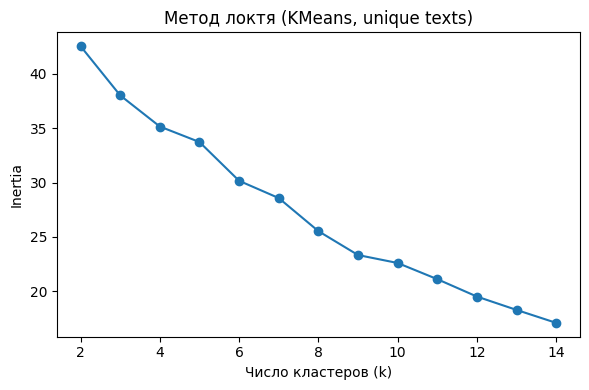

KMeans clusters (top): {10: 5399753, 9: 1730329, 8: 1706728, 11: 1402116, 7: 798915, 4: 120180, 3: 7071, 0: 7002, 5: 3394, 6: 61}


In [15]:
# Подбор k методом локтя на сэмпле из уникальных нормализованных текстов
rng = np.random.RandomState(42)
max_points = min(30000, Xn_u.shape[0])
sample_idx = rng.choice(Xn_u.shape[0], size=max_points, replace=False)
X_small = Xn_u[sample_idx]

inertias = []
K = range(2, 15)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096, n_init='auto')
    km.fit(X_small)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K), inertias, marker='o')
plt.xlabel('Число кластеров (k)')
plt.ylabel('Inertia')
plt.title('Метод локтя (KMeans, unique texts)')
plt.tight_layout()
plt.show()

# Финальный k
k = 12
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096, n_init='auto')
labels_u = kmeans.fit_predict(Xn_u)

df_u['cluster_kmeans'] = labels_u
# Маппим к исходным строкам
if 'cluster_kmeans' in df.columns:
    df.drop(columns=['cluster_kmeans'], inplace=True)
df = df.merge(df_u[['text_norm','cluster_kmeans']], on='text_norm', how='left')
print('KMeans clusters (top):', df['cluster_kmeans'].value_counts().head(10).to_dict())


### 3.1 Интерпретация кластеров KMeans (top terms + примеры)

Смотрим, какие слова/фразы наиболее характерны для каждого кластера.

In [17]:

feature_names = vectorizer.get_feature_names_out()

def top_terms_for_cluster(X_sparse, labels, cluster_id, topn=12):
    import numpy as np
    idx = np.where(labels == cluster_id)[0]
    if idx.size == 0:
        return []
    v = X_sparse[idx].mean(axis=0)
    v = np.asarray(v).ravel()
    top = v.argsort()[-topn:][::-1]
    return [feature_names[i] for i in top]

labels_km_u = df_u['cluster_kmeans'].to_numpy()

for c in range(min(k, 9)):
    print(f"Cluster {c} | size={(labels_km_u==c).sum()}")
    print('Top terms:', top_terms_for_cluster(X_u, labels_km_u, c, topn=12))
    ex = df_u.loc[df_u['cluster_kmeans']==c, 'text_norm'].head(2).tolist()
    print('Examples:')
    for e in ex:
        print(' -', e[:200])


Cluster 0 | size=2
Top terms: ['ip num', 'ip', 's', 'ask ip', 'block ask', 'to datanode', 'to replicate', 'replicate', 'replicate block', 'ask', 'datanode', 'datanode s']
Examples:
 - BLOCK* ask <IP>:<NUM> to replicate <BLOCK> to datanode(s) <IP>:<NUM>
 - BLOCK* ask <IP>:<NUM> to replicate <BLOCK> to datanode(s) <IP>:<NUM> <IP>:<NUM>
Cluster 1 | size=4
Top terms: ['path num', 'num', 'for', 'path', 'ch', 'sockettimeoutexception num', 'timeout while', 'to be', 'channel to', 'ch java', 'for channel', 'be ready']
Examples:
 - PacketResponder <BLOCK> <NUM> Exception java.net.SocketTimeoutException: <NUM> millis timeout while waiting for channel to be ready for read. ch : java.nio.channels.SocketChannel[connected local=<PATH
 - writeBlock <BLOCK> received exception java.net.SocketTimeoutException: <NUM> millis timeout while waiting for channel to be ready for read. ch : java.nio.channels.SocketChannel[connected local=<PATH>:
Cluster 2 | size=4
Top terms: ['packetresponder block', 'block num'

Для кластеризации логов использовался алгоритм KMeans на основе TF-IDF представления. Аналогичные подходы реализованы в специализированных библиотеках анализа логов (например, LogAI), однако в работе использована собственная реализация для обеспечения прозрачности и интерпретируемости экспериментов.

In [7]:
# Уникальные нормализованные сообщения + частоты (df_u)
print('Unique normalized texts:', len(df_u))
display(df_u.head(10))


Unique messages: 10335015


,text,cnt
0,dfs.DataNode$DataXceiver WARN 10.250.14.224:50...,15
1,dfs.DataNode$DataXceiver WARN 10.251.30.179:50...,13
2,dfs.DataNode$DataXceiver WARN 10.251.215.192:5...,13
3,dfs.FSDataset INFO Deleting block blk_-1608999...,10
4,dfs.DataNode$DataXceiver WARN 10.251.194.213:5...,10
5,dfs.DataNode$DataXceiver WARN 10.251.126.255:5...,10
6,dfs.DataNode$DataXceiver WARN 10.251.198.33:50...,9
7,dfs.DataNode$DataXceiver WARN 10.251.214.130:5...,9
8,dfs.DataNode$DataXceiver WARN 10.251.70.112:50...,9
9,dfs.DataNode$DataXceiver WARN 10.250.11.53:500...,9


## 4) DBSCAN кластеризация (через SVD до 100D)

DBSCAN в исходной high‑dim TF‑IDF часто нестабилен, поэтому сперва сжимаем пространство.
`-1` в DBSCAN = “шум/аномальные сообщения”.

In [18]:

# DBSCAN на сокращённом представлении (через SVD до 100D) для уникальных текстов
svd = TruncatedSVD(n_components=100, random_state=42)
X100_u = svd.fit_transform(Xn_u)

# стартовые параметры; при необходимости подбираются
db = DBSCAN(eps=1.2, min_samples=5, metric='euclidean', n_jobs=-1)
labels_db_u = db.fit_predict(X100_u)

df_u['cluster_dbscan'] = labels_db_u
# Маппим к исходным строкам
if 'cluster_dbscan' in df.columns:
    df.drop(columns=['cluster_dbscan'], inplace=True)
df = df.merge(df_u[['text_norm','cluster_dbscan']], on='text_norm', how='left')

n_clusters = len(set(labels_db_u)) - (1 if -1 in set(labels_db_u) else 0)
n_noise = int((labels_db_u == -1).sum())
print('DBSCAN clusters:', n_clusters)
print('Noise (-1):', n_noise, f'({n_noise/len(df_u):.2%})')
display(df['cluster_dbscan'].value_counts().head(10))


DBSCAN clusters: 1
Noise (-1): 2 (3.70%)


cluster_dbscan
 0    9469111
-1    1706518
Name: count, dtype: int64

Плотностная кластеризация DBSCAN выявила один основной кластер, соответствующий нормальному режиму работы системы, и небольшую долю шумовых сообщений. Это указывает на высокую однородность логов и наличие ограниченного числа редких паттернов, что характерно для стабильных распределённых систем.

## 5) Визуализация кластеров: PCA и t‑SNE

Чтобы t‑SNE работал быстро — визуализируем подвыборку.

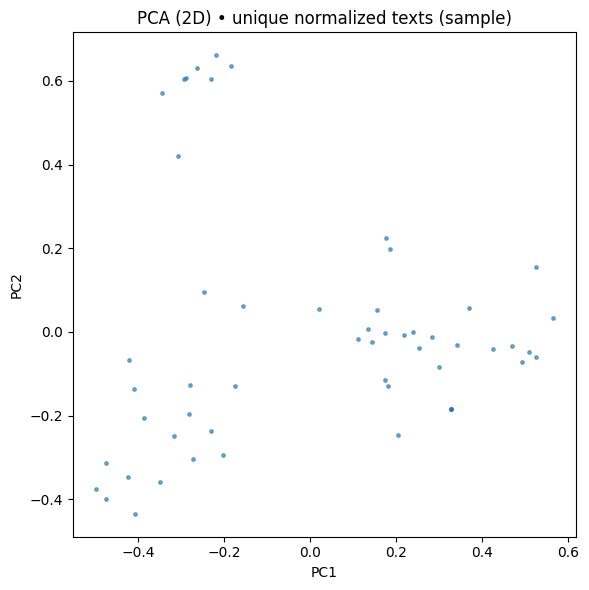

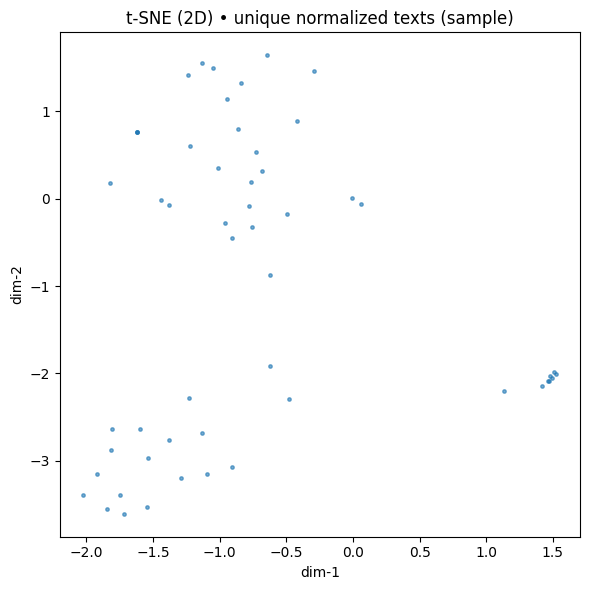

In [19]:

MAX_VIS = 5000
rng = np.random.RandomState(42)
idx = rng.choice(len(df_u), size=min(MAX_VIS, len(df_u)), replace=False)

# PCA(2D) на X100_u
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X100_u[idx])

plt.figure(figsize=(6,6))
plt.scatter(X2[:,0], X2[:,1], s=6, alpha=0.6)
plt.title('PCA (2D) • unique normalized texts (sample)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.tight_layout()
plt.show()

# t-SNE на PCA-координатах
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X2)

plt.figure(figsize=(6,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=6, alpha=0.6)
plt.title('t-SNE (2D) • unique normalized texts (sample)')
plt.xlabel('dim-1'); plt.ylabel('dim-2'); plt.tight_layout()
plt.show()


Визуализация нормализованных лог-сообщений с помощью PCA и t-SNE показала высокую однородность данных с наличием небольшого числа локальных групп. Это указывает на доминирование одного основного режима работы системы и наличие ограниченного количества редких типов сообщений, что характерно для стабильных распределённых систем и соответствует постановке задачи детекции аномалий.

## 6) Сохранение результатов

In [20]:
out_cols = [c for c in ["timestamp","level","component","message","BlockId","pid","cluster_kmeans","cluster_dbscan"] if c in df.columns]
df[out_cols].to_parquet("punkt6_logs_clustered.parquet", index=False)
print("Saved: punkt6_logs_clustered.parquet")

# примеры шумов DBSCAN
if (df.get("cluster_dbscan") is not None) and (df["cluster_dbscan"]==-1).any():
    display(df.loc[df["cluster_dbscan"]==-1, out_cols].head(10))

Saved: punkt6_logs_clustered.parquet


,timestamp,level,component,message,BlockId,pid,cluster_kmeans,cluster_dbscan
5,2008-11-11 09:44:54,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000002529962039464 of siz...,blk_-1000002529962039464,25852,10,-1
7,2008-11-11 09:44:54,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000002529962039464 of siz...,blk_-1000002529962039464,25868,10,-1
12,2008-11-11 09:44:55,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000002529962039464 of siz...,blk_-1000002529962039464,25371,10,-1
21,2008-11-10 02:01:41,INFO,dfs.DataNode$PacketResponder,Received block blk_-100000266894974466 of size...,blk_-100000266894974466,5853,10,-1
23,2008-11-10 02:01:41,INFO,dfs.DataNode$PacketResponder,Received block blk_-100000266894974466 of size...,blk_-100000266894974466,6105,10,-1
25,2008-11-10 02:01:41,INFO,dfs.DataNode$PacketResponder,Received block blk_-100000266894974466 of size...,blk_-100000266894974466,6169,10,-1
46,2008-11-11 09:47:17,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000007292892887521 of siz...,blk_-1000007292892887521,25656,10,-1
48,2008-11-11 09:47:17,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000007292892887521 of siz...,blk_-1000007292892887521,25844,10,-1
50,2008-11-11 09:47:17,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000007292892887521 of siz...,blk_-1000007292892887521,26132,10,-1
62,2008-11-10 01:51:58,INFO,dfs.DataNode$PacketResponder,Received block blk_-1000014584150379967 of siz...,blk_-1000014584150379967,5888,10,-1


KMeans использовался для группировки лог-сообщений по семантической близости, тогда как DBSCAN — для выявления плотных областей и редких сообщений. В результате часть сообщений была отнесена KMeans к типовым кластерам, но при этом помечена DBSCAN как шум, что указывает на их низкую плотность и потенциальную аномальность.

## Выводы (коротко)

- **TF‑IDF** переводит текст логов в числовые вектора.  
- **KMeans** группирует сообщения в устойчивые “типы”.  
- **DBSCAN** может выделить редкие/аномальные сообщения как `-1`.  
- **PCA и t‑SNE** дают 2D‑визуализацию распределения лог‑сообщений (на подвыборке).